In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
import matplotlib.lines as mlines

from dmlutils.building_upgrades import upgrades
from dmlutils.gcs import save_fig_to_gcs

import src.globals as g

## Load test set error metrics and aggregated error metrics

In [0]:
building_upgrade_zone_type = (
    spark.table(f"{g.BUILDING_FEATURE_TABLE}_{g.CURRENT_VERSION_NUM}")
    .withColumn("zone_type", F.regexp_extract("hvac_heating_efficiency", r"(MZ|SZ)", 0))
    .select("building_id", "upgrade_id", "zone_type")
    .toPandas()
)

In [0]:
g.CURRENT_VERSION_NUM

'perf_curve_param_oem_hp_only_experiment'

In [0]:
predictions = pd.read_csv(str(g.GCS_CURRENT_VERSION_ARTIFACT_PATH / "prediction_metrics_test_set.csv")).query(
    "fuel == 'total'"
)[["building_id", "upgrade_id", "actual", "prediction"]]

predictions = pd.read_csv(
    str(g.GCS_ARTIFACT_PATH / "oem_hp_only_experiment" / "prediction_metrics_test_set.csv")
).query("fuel == 'total'")[["building_id", "upgrade_id", "actual", "prediction"]]

predictions = predictions.merge(building_upgrade_zone_type, on=["upgrade_id", "building_id"])

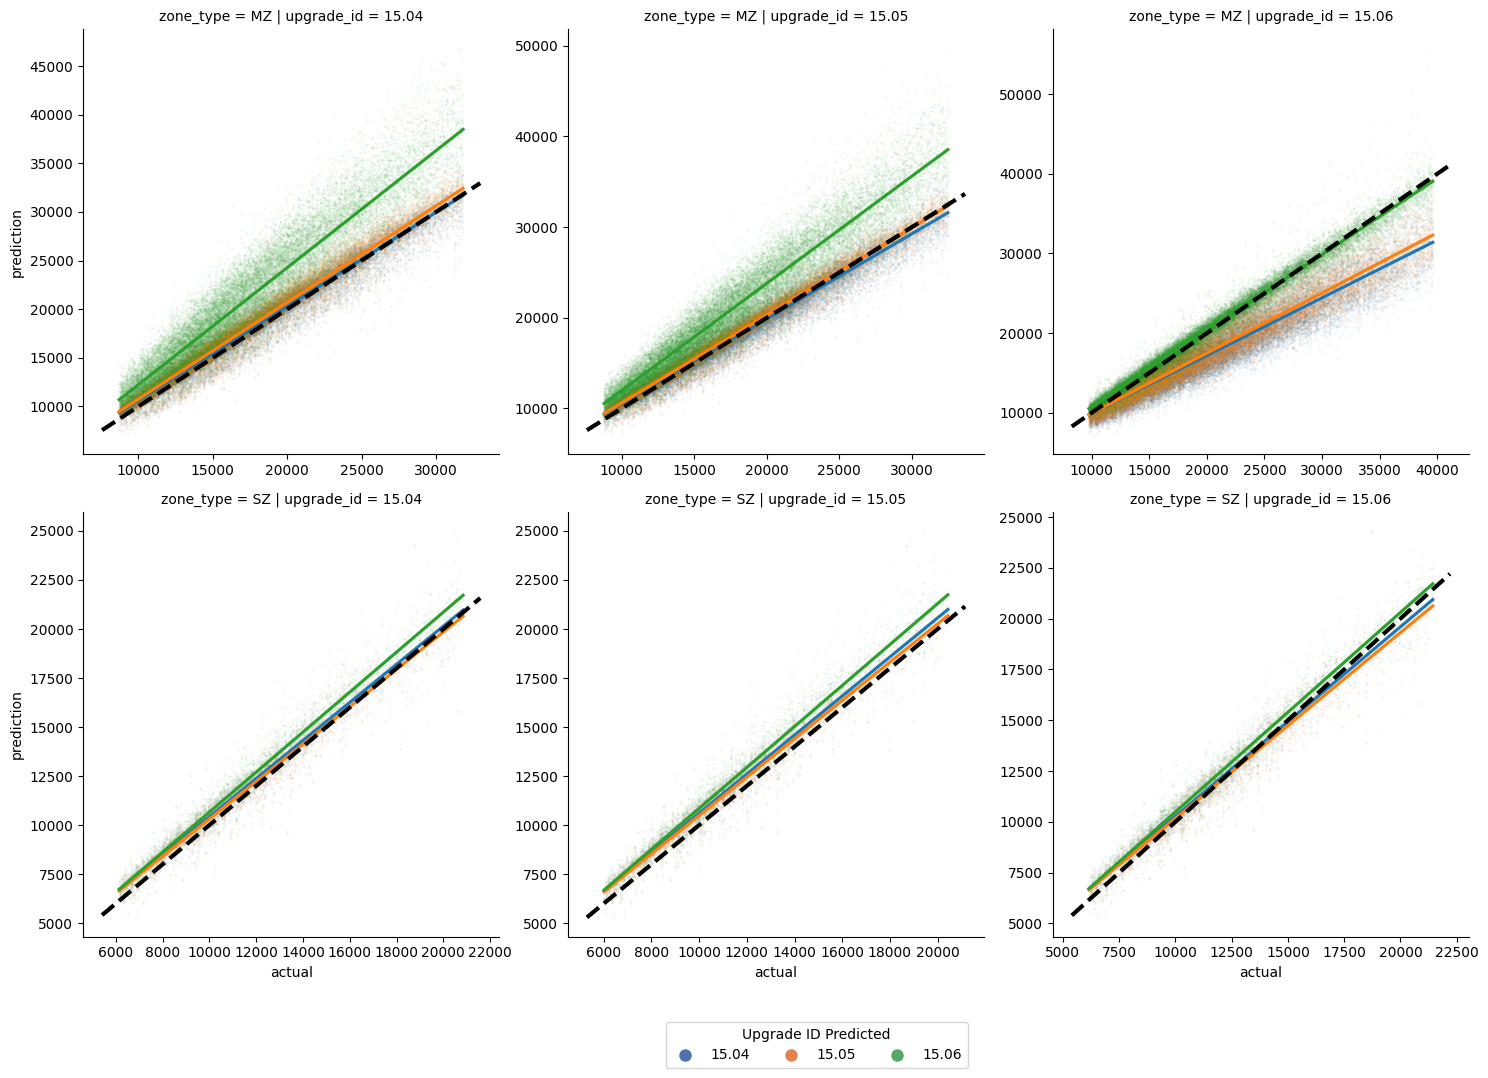

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt


predictions_all_upgrade_ids = predictions.drop("prediction", axis=1).merge(
    predictions.drop("actual", axis=1), on=["building_id", "zone_type"], suffixes=["", "_predicted"]
)

# Filter the data as you originally did
df_filtered = (
    predictions_all_upgrade_ids.groupby(["upgrade_id", "zone_type"])
    .apply(
        lambda group: group[
            (group["actual"] > group["actual"].quantile(0.05))
            & (group["actual"] < group["actual"].quantile(0.95))  # Remove bottom 5%  # Remove top 5%
        ]
    )
    .reset_index(drop=True)
)

# Create the lmplot
g = sns.lmplot(
    x="actual",
    y="prediction",
    hue="upgrade_id_predicted",
    col="upgrade_id",
    row="zone_type",
    data=df_filtered,
    facet_kws={"sharex": False, "sharey": False},
    scatter_kws={"s": 0.05, "alpha": 0.2},
)

# Add a y=x line to each facet
for ax in g.axes.flat:
    ax.plot(ax.get_xlim(), ax.get_xlim(), color="black", ls="--", label="y=x", lw=3)

# Create a color palette for the hue categories
palette = sns.color_palette("deep", n_colors=len(df_filtered["upgrade_id_predicted"].unique()))

# Customize the legend to use solid color patches
handles = [
    mlines.Line2D([0], [0], marker="o", color="w", markerfacecolor=palette[i], markersize=10, label=str(hue))
    for i, hue in enumerate(df_filtered["upgrade_id_predicted"].unique())
]

# Remove the default legend and add the custom one
g._legend.remove()
g.fig.legend(handles=handles, title="Upgrade ID Predicted", loc="center", bbox_to_anchor=(0.5, -0.05), ncol=3)

# Show the plot
plt.show()

In [0]:
%pip install mlflow==2.13.0
dbutils.library.restartPython()

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [0]:
import mlflow
import numpy as np
import pandas as pd
import pyspark.sql.functions as F
from pyspark.sql import DataFrame, Column
from pyspark.sql.window import Window


from src.globals import GCS_CURRENT_VERSION_ARTIFACT_PATH
from src.datagen import DataGenerator, load_data
from src.surrogate_model import SurrogateModel

2025-03-27 12:41:31.793358: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [0]:
# load test data
_, _, test_data = load_data(n_test=100)
# init data generator so we can get all of the features -- note that we can't use databricks automatic lookup of features since we logged with mlflow
test_gen = DataGenerator(test_data)
# reload the training set but with building id and upgrade id keys which we need (this is a little hacky..)
test_set = test_gen.init_training_set(train_data=test_data, exclude_columns=["weather_file_city"]).load_df()
# convert from pyspark to pandas so we can run inference
inference_data = test_set.toPandas()

In [0]:
# init model
sm = SurrogateModel()
# mlflow.pyfunc.get_model_dependencies(model_uri=sm.get_model_uri(run_id=RUN_ID))
# Load the unregistered model using run ID
model = mlflow.pyfunc.load_model(model_uri=sm.get_model_uri(run_id="af6dd687ec494a97a7ab32fcc542f67e"))  # without perf
model_w_perf_metrics = mlflow.pyfunc.load_model(
    model_uri=sm.get_model_uri(run_id="02ef6330c3d54e27b3a0c9442ac70309")
)  #

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def analyze_feature_impact(model, inference_data, feature_name, grid_values=None, num_points=50):
    """
    Analyze how model predictions change when varying one feature (batch version).

    Args:
        model: Loaded TensorFlow model
        inference_data: Original DataFrame with samples
        feature_name: Name of feature to vary
        grid_values: Specific values to test (optional)
        num_points: Number of points if grid_values not provided

    Returns:
        DataFrame with results and displays a plot
    """
    # Create a copy of the original data to avoid modifying it
    original_data = inference_data.copy()

    # If grid values not provided, create a linear space
    if grid_values is None:
        min_val = original_data[feature_name].min()
        max_val = original_data[feature_name].max()
        grid_values = np.linspace(min_val, max_val, num_points)

    # Create all modified datasets at once
    batch_data = pd.concat([original_data.assign(**{feature_name: value}) for value in grid_values], ignore_index=True)

    # Add identifier for which grid value each row belongs to
    batch_data["_grid_value"] = np.repeat(grid_values, len(original_data))

    # Run single batch prediction
    predictions = np.nansum(model.predict(batch_data), axis=1)

    # Add predictions to the batch data
    batch_data["_prediction"] = predictions

    # Group by grid value and calculate statistics
    results = (
        batch_data.groupby("_grid_value")["_prediction"].agg(["mean", "median", "std", "min", "max"]).reset_index()
    )
    results.columns = [
        "feature_value",
        "mean_prediction",
        "median_prediction",
        "std_prediction",
        "min_prediction",
        "max_prediction",
    ]

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(results["feature_value"], results["mean_prediction"], label="Mean Prediction", color="blue")
    plt.fill_between(
        results["feature_value"],
        results["mean_prediction"] - results["std_prediction"],
        results["mean_prediction"] + results["std_prediction"],
        alpha=0.2,
        color="blue",
    )

    plt.xlabel(feature_name)
    plt.ylabel("Prediction Sum")
    plt.title(f"Impact of {feature_name} on Model Predictions (Batch)")
    plt.legend()
    plt.grid(True)
    plt.show()

    return results

30/30 [==============================] - 2s 28ms/step


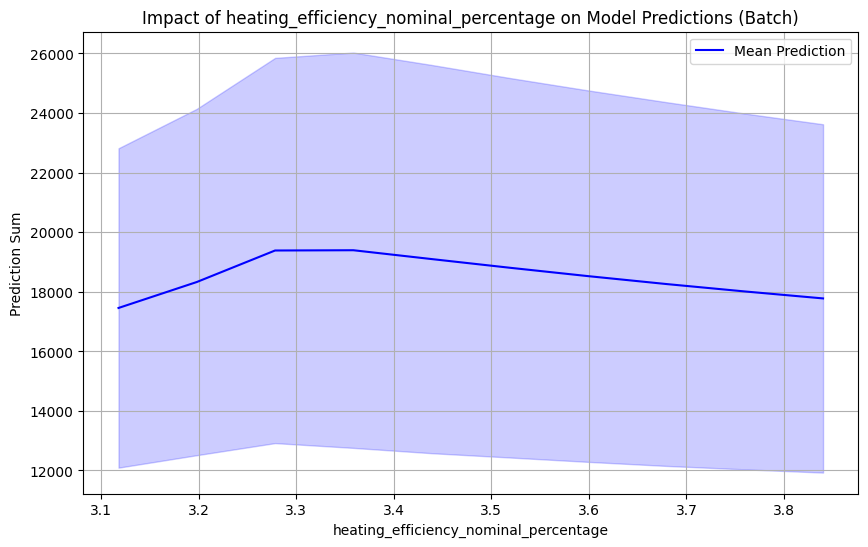

In [0]:
results = analyze_feature_impact(
    model=model, inference_data=inference_data, feature_name="heating_efficiency_nominal_percentage", num_points=10
)

30/30 [==============================] - 1s 26ms/step


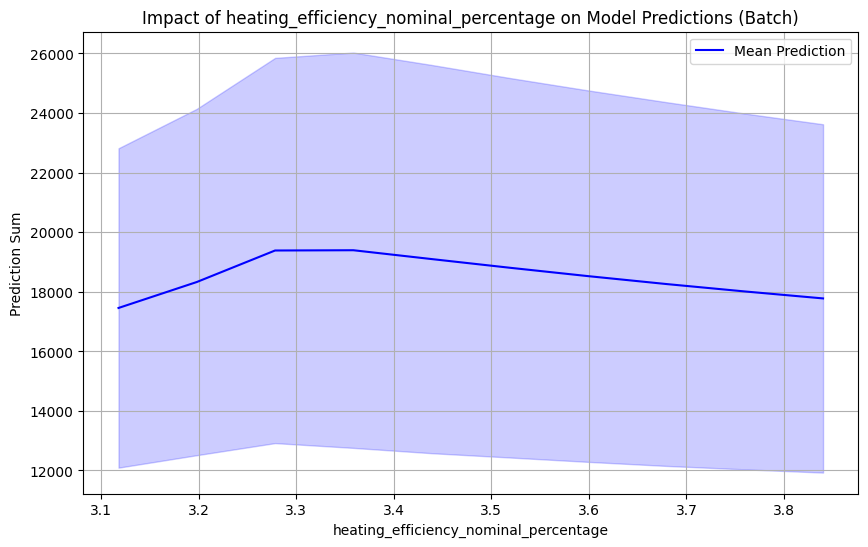

In [0]:
# Example usage:

# Or with specific grid values:
# custom_grid = np.linspace(3, 4, 4)  # from 0 to 1 in 20 steps
results = analyze_feature_impact(
    model=model, inference_data=inference_data, feature_name="heating_efficiency_nominal_percentage", num_points=10
)

30/30 [==============================] - 1s 25ms/step


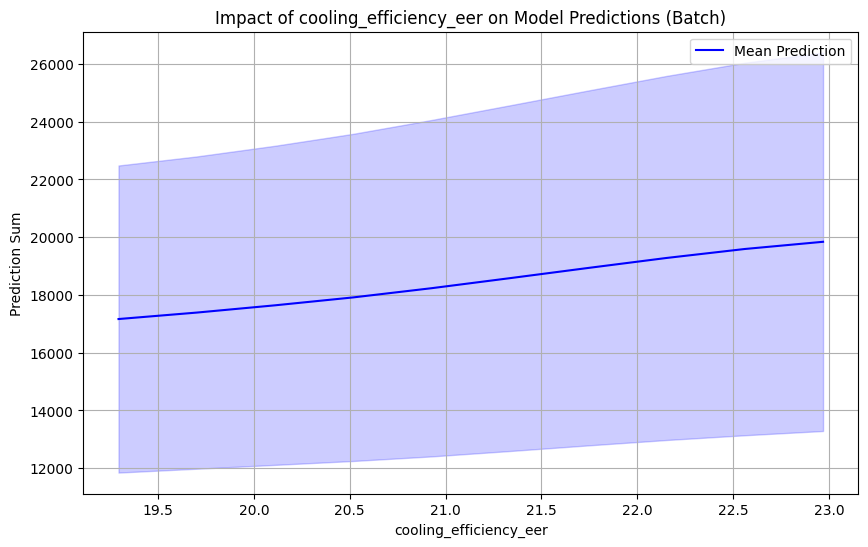

In [0]:
# Example usage:

# Or with specific grid values:
custom_grid = np.linspace(19, 23, 4)  # from 0 to 1 in 20 steps
results = analyze_feature_impact(
    model=model, inference_data=inference_data, feature_name="cooling_efficiency_eer", num_points=10
)

30/30 [==============================] - 2s 26ms/step


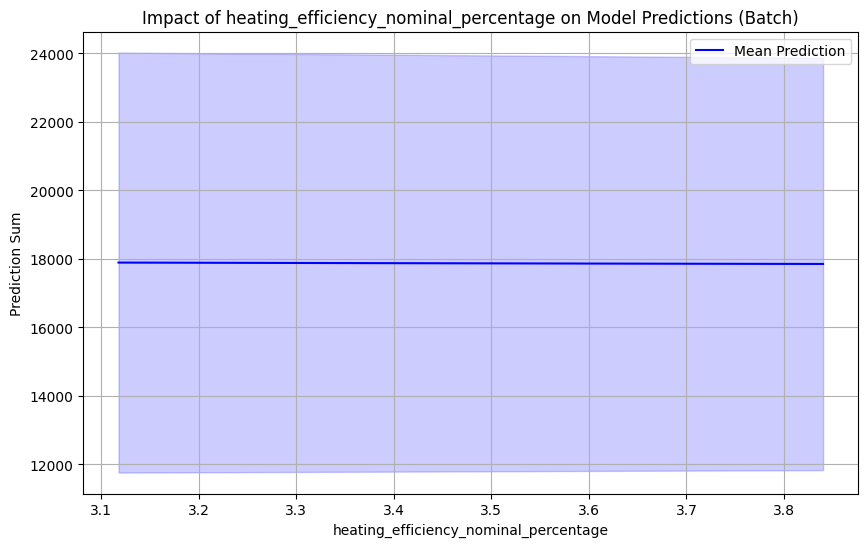

In [0]:
# Example usage:

# Or with specific grid values:
custom_grid = np.linspace(3, 4, 4)  # from 0 to 1 in 20 steps
results = analyze_feature_impact(
    model=model_w_perf_metrics,
    inference_data=inference_data,
    feature_name="heating_efficiency_nominal_percentage",
    num_points=10,
)

30/30 [==============================] - 1s 24ms/step


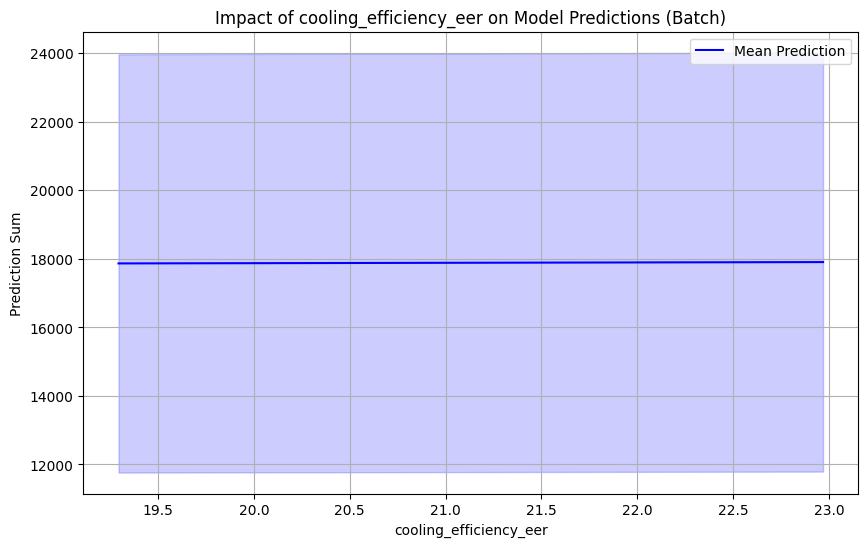

In [0]:
custom_grid = np.linspace(19, 23, 4)  # from 0 to 1 in 20 steps
results = analyze_feature_impact(
    model=model_w_perf_metrics, inference_data=inference_data, feature_name="cooling_efficiency_eer", num_points=10
)

30/30 [==============================] - 1s 24ms/step


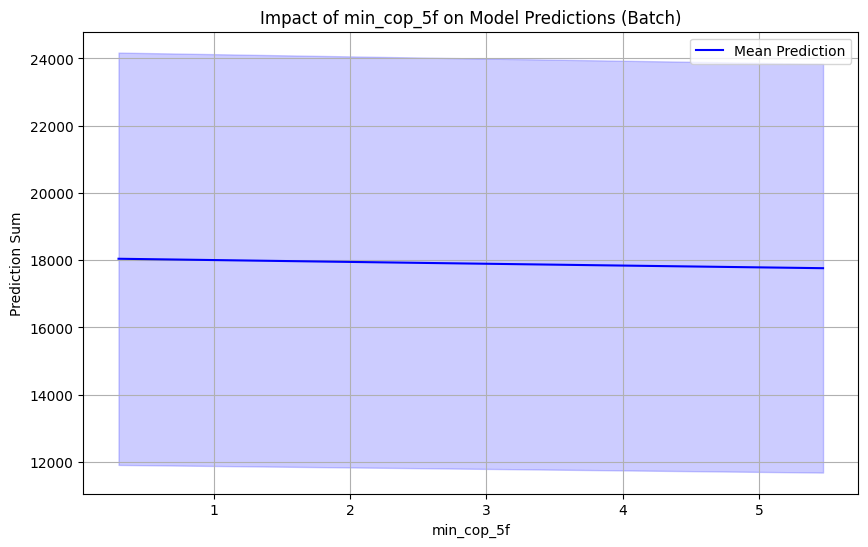

In [0]:
custom_grid = np.linspace(0, 6, 10)  # from 0 to 1 in 20 steps
results = analyze_feature_impact(
    model=model_w_perf_metrics, inference_data=inference_data, feature_name="min_cop_5f", num_points=10
)

30/30 [==============================] - 1s 24ms/step


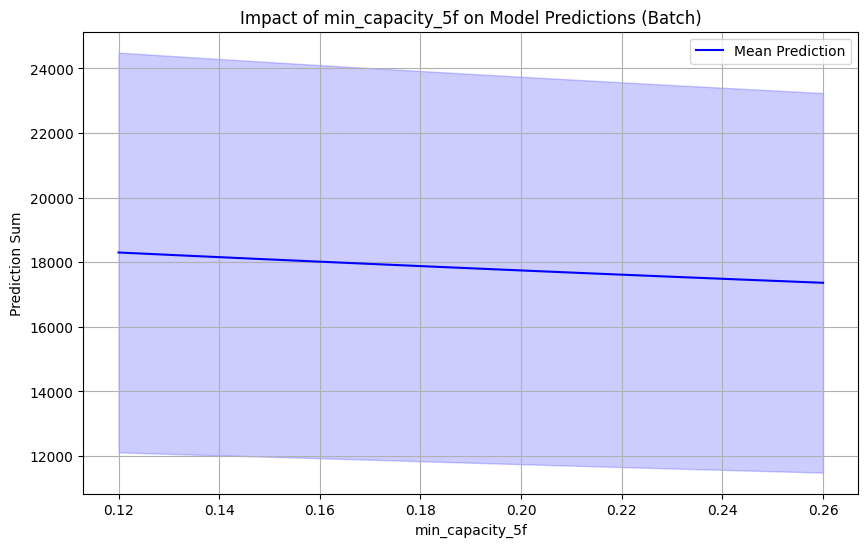

In [0]:
results = analyze_feature_impact(
    model=model_w_perf_metrics, inference_data=inference_data, feature_name="min_capacity_5f", num_points=10
)

In [0]:
spark.table(f"{g.BUILDING_FEATURE_TABLE}_{g.CURRENT_VERSION_NUM}").withColumn(
    "zone_type", F.regexp_extract("hvac_heating_efficiency", r"(MZ|SZ)", 0)
).select("min_cop_47f", "upgrade_id", "zone_type").distinct().display()

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-7259820720206134>, line 1
----> 1 spark.table(f"{g.BUILDING_FEATURE_TABLE}_{g.CURRENT_VERSION_NUM}").withColumn(
      2     "zone_type", F.regexp_extract("hvac_heating_efficiency", r"(MZ|SZ)", 0)
      3 ).select("min_cop_47f", "upgrade_id", "zone_type").distinct().display()

NameError: name 'g' is not defined